<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_02_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages("janeaustenr") # a new package to access a particular author's works in the Gutenberg repository
install.packages("tidytext") # in colab, we need to reinstall for each new runtime (on your own machine, install only once)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘hunspell’, ‘tokenizers’




In [4]:
library(dplyr)
library(janeaustenr) 
library(tidytext)

# following Chapter 3 of the R textbook, we will use each of Austen's books as a "document" and her total works as the corpus

# count words by book
bw <- austen_books() %>% unnest_tokens(word, text) %>% count(book, word, sort = TRUE) %>% ungroup()
head(bw)
# count the total word frequency
tw <- bw %>% group_by(book) %>% summarize(total = sum(n))
head(tw)
# combine the by-book frequencies with the total frequencies 
wf <- left_join(bw, tw)
head(wf)

book,word,n
<fct>,<chr>,<int>
Mansfield Park,the,6206
Mansfield Park,to,5475
Mansfield Park,and,5438
Emma,to,5239
Emma,the,5201
Emma,and,4896


book,total
<fct>,<int>
Sense & Sensibility,119957
Pride & Prejudice,122204
Mansfield Park,160460
Emma,160996
Northanger Abbey,77780
Persuasion,83658


Joining, by = "book"


book,word,n,total
<fct>,<chr>,<int>,<int>
Mansfield Park,the,6206,160460
Mansfield Park,to,5475,160460
Mansfield Park,and,5438,160460
Emma,to,5239,160996
Emma,the,5201,160996
Emma,and,4896,160996


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 107 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


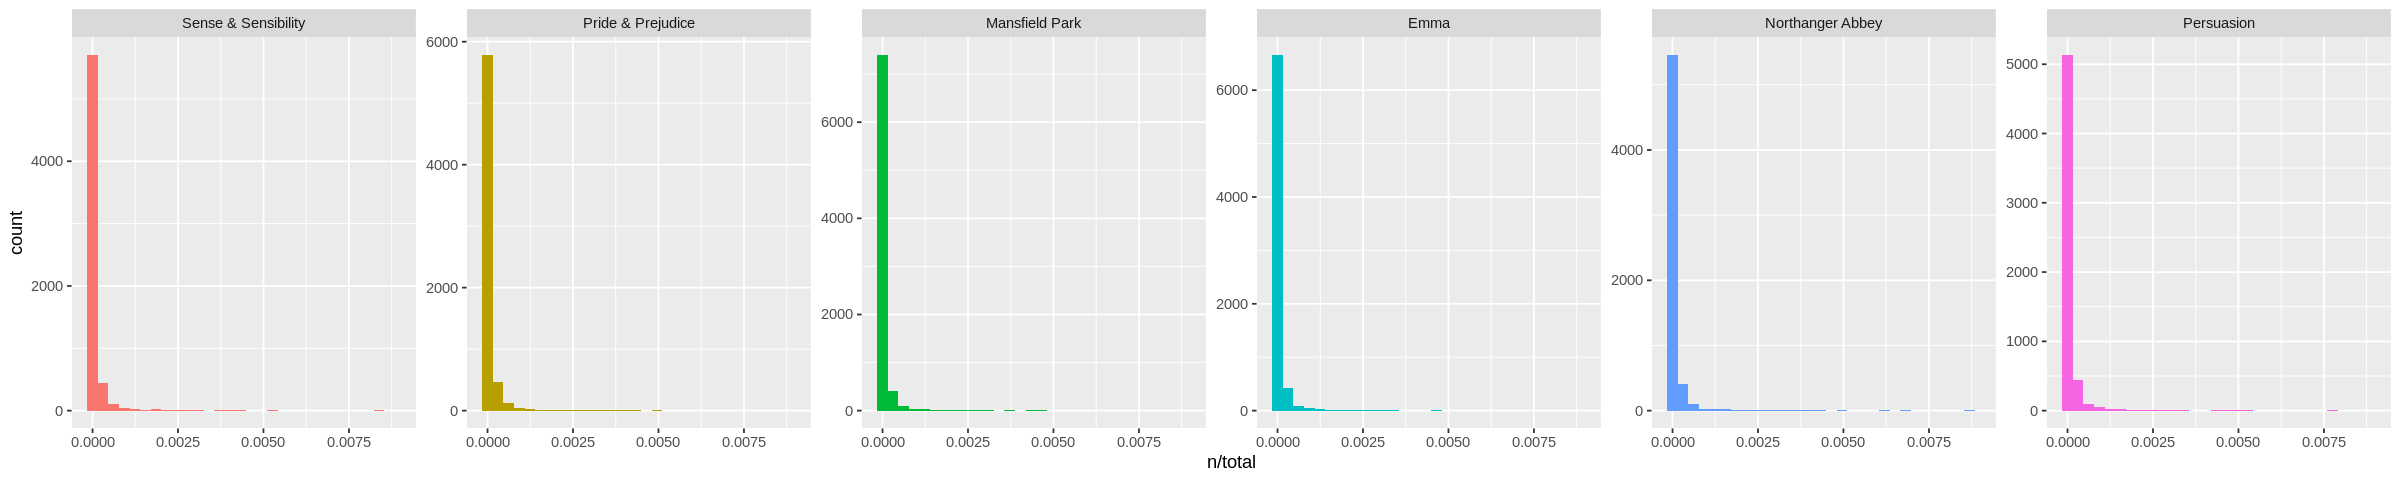

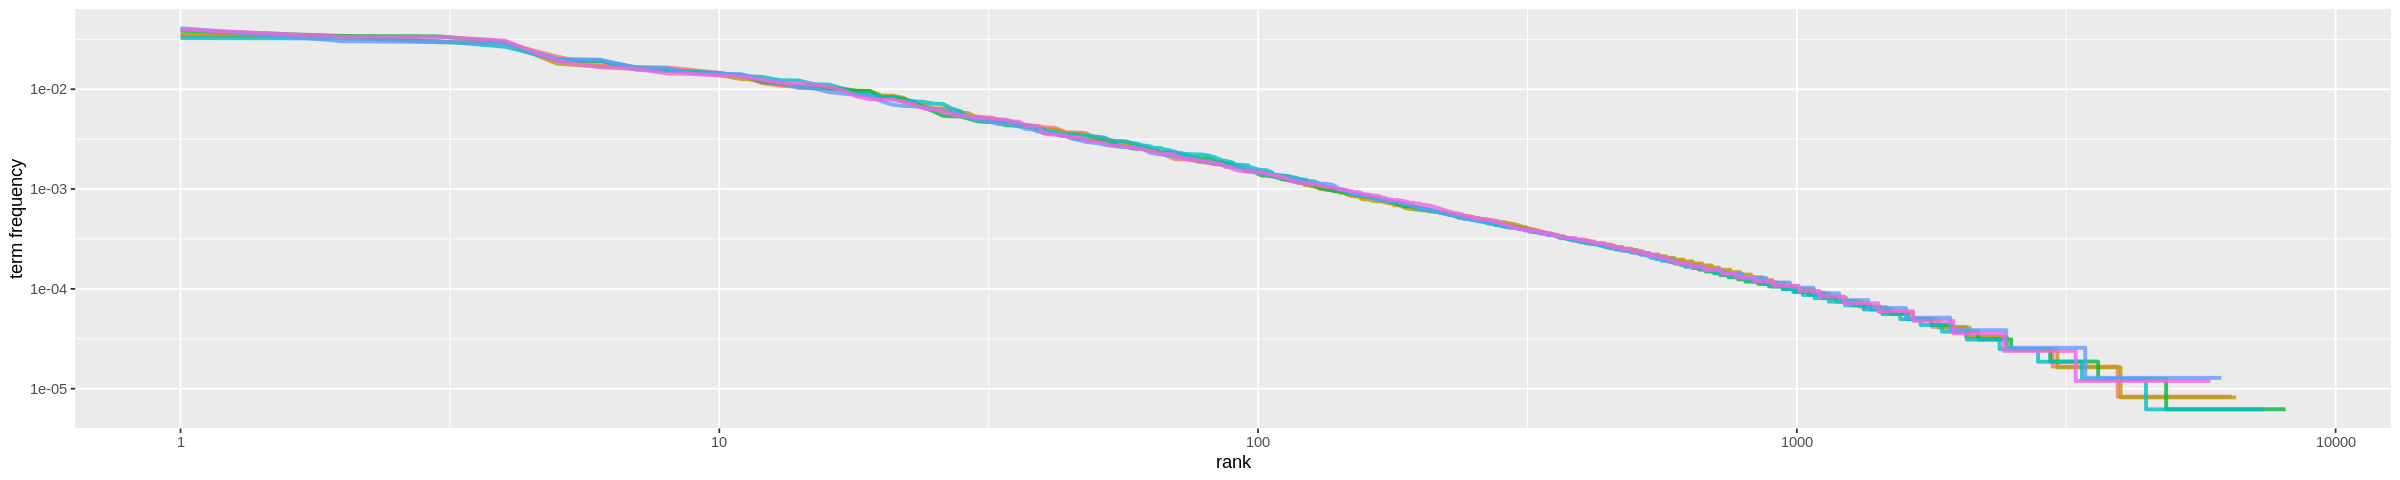

In [14]:
library(ggplot2)
library(repr)
options(repr.plot.width = 20, repr.plot.height = 4) # a wider, shorter figure
# these will all be heavy-tailed distributions (as predicted by Zipf's Law)
ggplot(wf, aes(n / total, fill = book)) + geom_histogram(show.legend = FALSE) + xlim(NA, 0.009) + facet_wrap(~book, ncol = 6, scales = "free_y")
# this means they make sort of a straight line in a log-log plot (with noise at the start and at the end)
fr <- wf %>% group_by(book) %>% mutate(rank = row_number(), `term frequency` = n / total) # rank the words by frequency
fr %>% ggplot(aes(rank, `term frequency`, color = book)) + geom_line(size = 1.1, alpha = 0.8, show.legend = FALSE) + scale_x_log10() + scale_y_log10()

This heavy-tailedness is the reasoning behind inverse-document frequency: the words that are very common across the corpus do not allow us to differentiate the documents in terms of their *topics*. The `tidytext` package lets us compute the tf-idf without having to do the raw arithmetic.

In [18]:
wf <- wf %>% bind_tf_idf(word, book, n) # add three new columns: tf, idf, and tf_idf
ordered <- wf %>% select(-total) %>% arrange(desc(tf_idf)) # put the highest tf_idf terms first
head(ordered)

book,word,n,tf,idf,tf_idf
<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Sense & Sensibility,elinor,623,0.005193528,1.791759,0.009305552
Sense & Sensibility,marianne,492,0.004101470,1.791759,0.007348847
Mansfield Park,crawford,493,0.003072417,1.791759,0.005505032
Pride & Prejudice,darcy,373,0.003052273,1.791759,0.005468939
Persuasion,elliot,254,0.003036171,1.791759,0.005440088
Emma,emma,786,0.004882109,1.098612,0.005363545


It is not a surprise that we are seeing the names of the main characters in each book. Cleaning them out as we did in Session 1 is a good exercise. Let's build a term-document matrix in which we now place the tf-idf of the term instead of the raw frequency of appearance.

In [25]:
install.packages("tm") # this is another text mining package on which tidytext builds; install it if you do not have it yet
# consult the documentation at https://cran.r-project.org/web/packages/tm/vignettes/tm.pdf

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



<<DocumentTermMatrix (documents: 6, terms: 14520)>>
Non-/sparse entries: 40379/46741
Sparsity           : 54%
Maximal term length: 19
Weighting          : term frequency (tf)

In [46]:
# let's first filter out the lower end of the tf-idf scores
threshold <- 0.0005
top <- wf %>% filter (tf_idf > threshold) 
matrix <- top %>% cast_dtm(book, word, tf_idf)
matrix # see the stats

<<DocumentTermMatrix (documents: 6, terms: 120)>>
Non-/sparse entries: 122/598
Sparsity           : 83%
Maximal term length: 13
Weighting          : term frequency (tf)

Would be nice to see the data itself, in case there are any cool patterns.

In [47]:
df <- tidy(matrix)
head(df)

document,term,count
<chr>,<chr>,<dbl>
Mansfield Park,fanny,0.0035249165
Emma,emma,0.0053635448
Sense & Sensibility,elinor,0.0093055524
Pride & Prejudice,elizabeth,0.0033862138
Persuasion,elizabeth,0.0006794098
Mansfield Park,crawford,0.0055050319


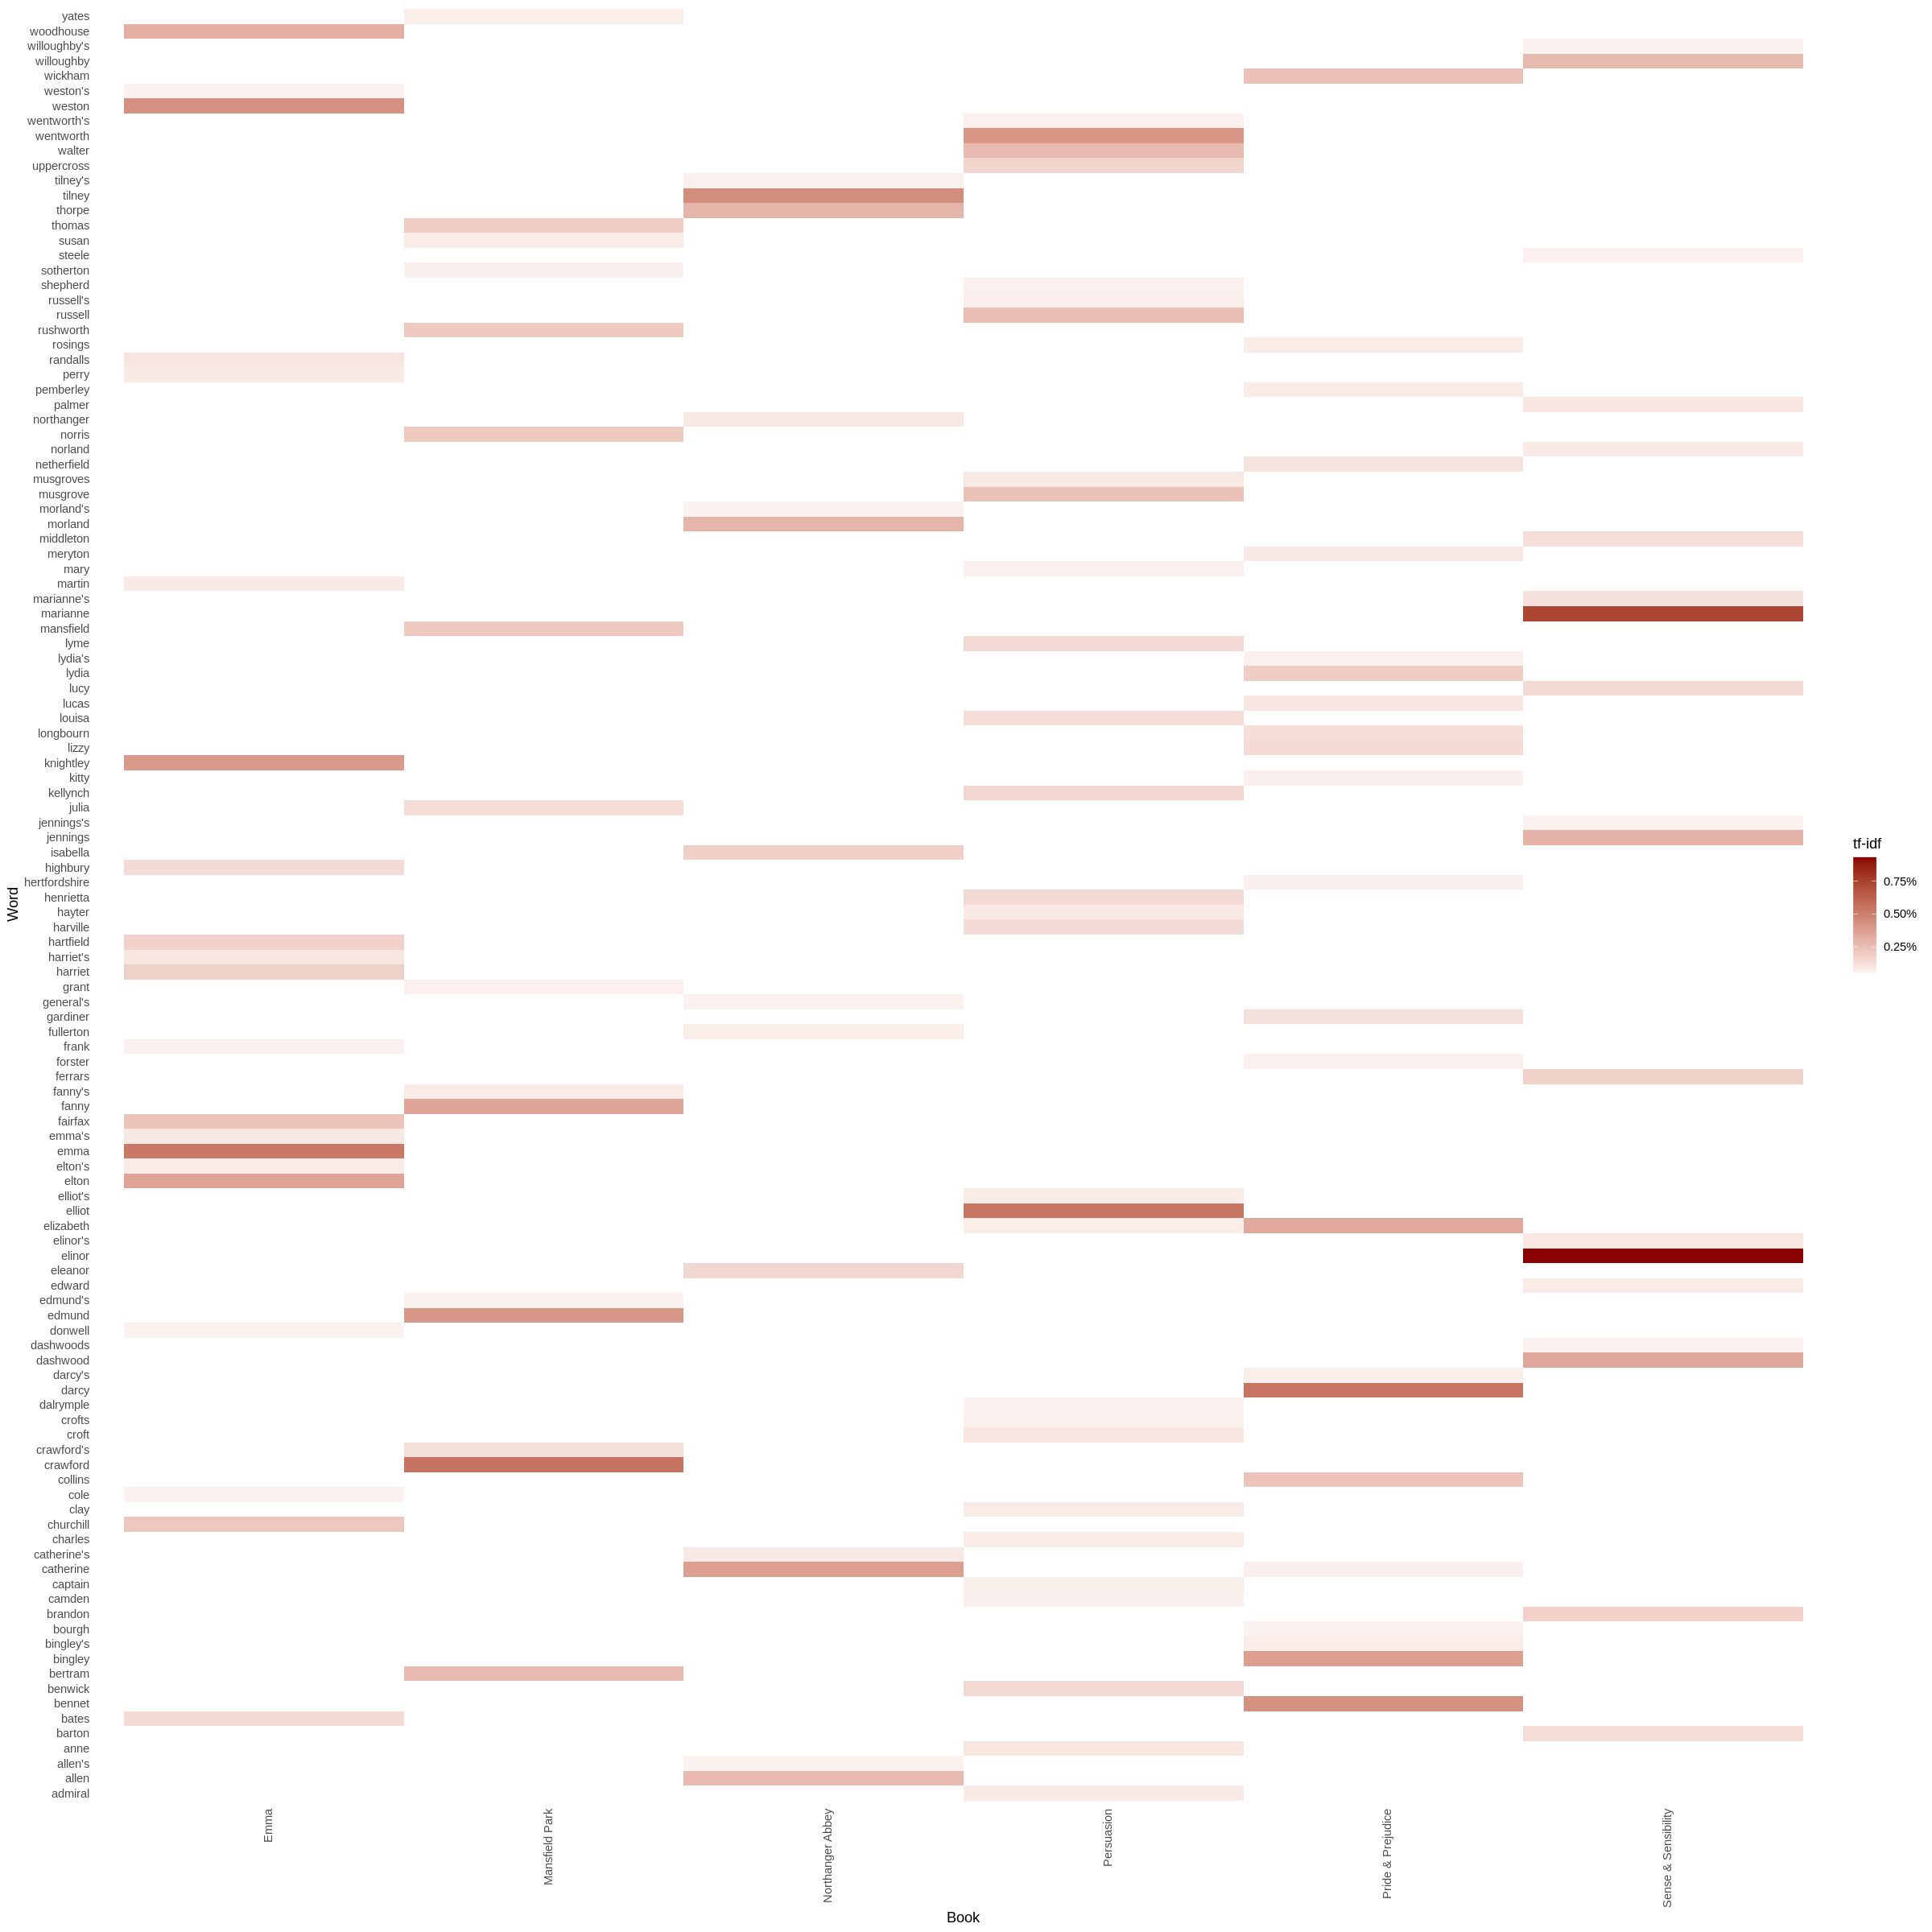

In [48]:
library(scales)
options(repr.plot.width = 20, repr.plot.height = 20) # a square is good now
df %>%
  ggplot(aes(document, term, fill = count)) + geom_tile() + scale_fill_gradient2(high = "darkred", label = percent_format()) +
  theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1), panel.grid = element_blank()) +
  labs(x = "Book", y = "Word", fill = "tf-idf")

Now, let's carry out LDA on this data.

In [61]:
system2("sudo", "apt-get install libgsl0-dev") # on your own linux machine, you would use sudo apt-get install libgsl0-dev (please consider installing a Linux VM unless you already have access to a Linux machine)
install.packages("topicmodels")
install.packages("reshape")
install.packages("reshape2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [86]:
library(topicmodels)
dtm <- top %>% cast_dtm(book, word, n) # we start from the regular TDM
k <- 3 # how many topics are we expecting to detect (this could be tuned much like for k-means)
model <- LDA(dtm, k) 
topics <- tidy(model, matrix = "beta")
head(topics)

topic,term,beta
<int>,<chr>,<dbl>
1,fanny,5.968401e-54
2,fanny,1.293595e-01
3,fanny,1.414379e-49
1,emma,9.245971e-02
2,emma,1.903623e-43
3,emma,3.698382e-53


In [71]:
install.packages("wordcloud")
install.packages("RColorBrewer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,1,2,3
fanny,2.307809e-71,8.191120e-67,2.363847e-01
emma,7.820117e-02,1.024271e-46,2.517118e-60
elinor,6.198388e-02,1.227783e-66,4.763737e-62
elizabeth,5.939707e-02,1.922175e-02,6.561146e-62
crawford,3.777004e-70,3.438058e-68,1.428158e-01
marianne,4.895035e-02,2.723561e-66,1.280737e-61


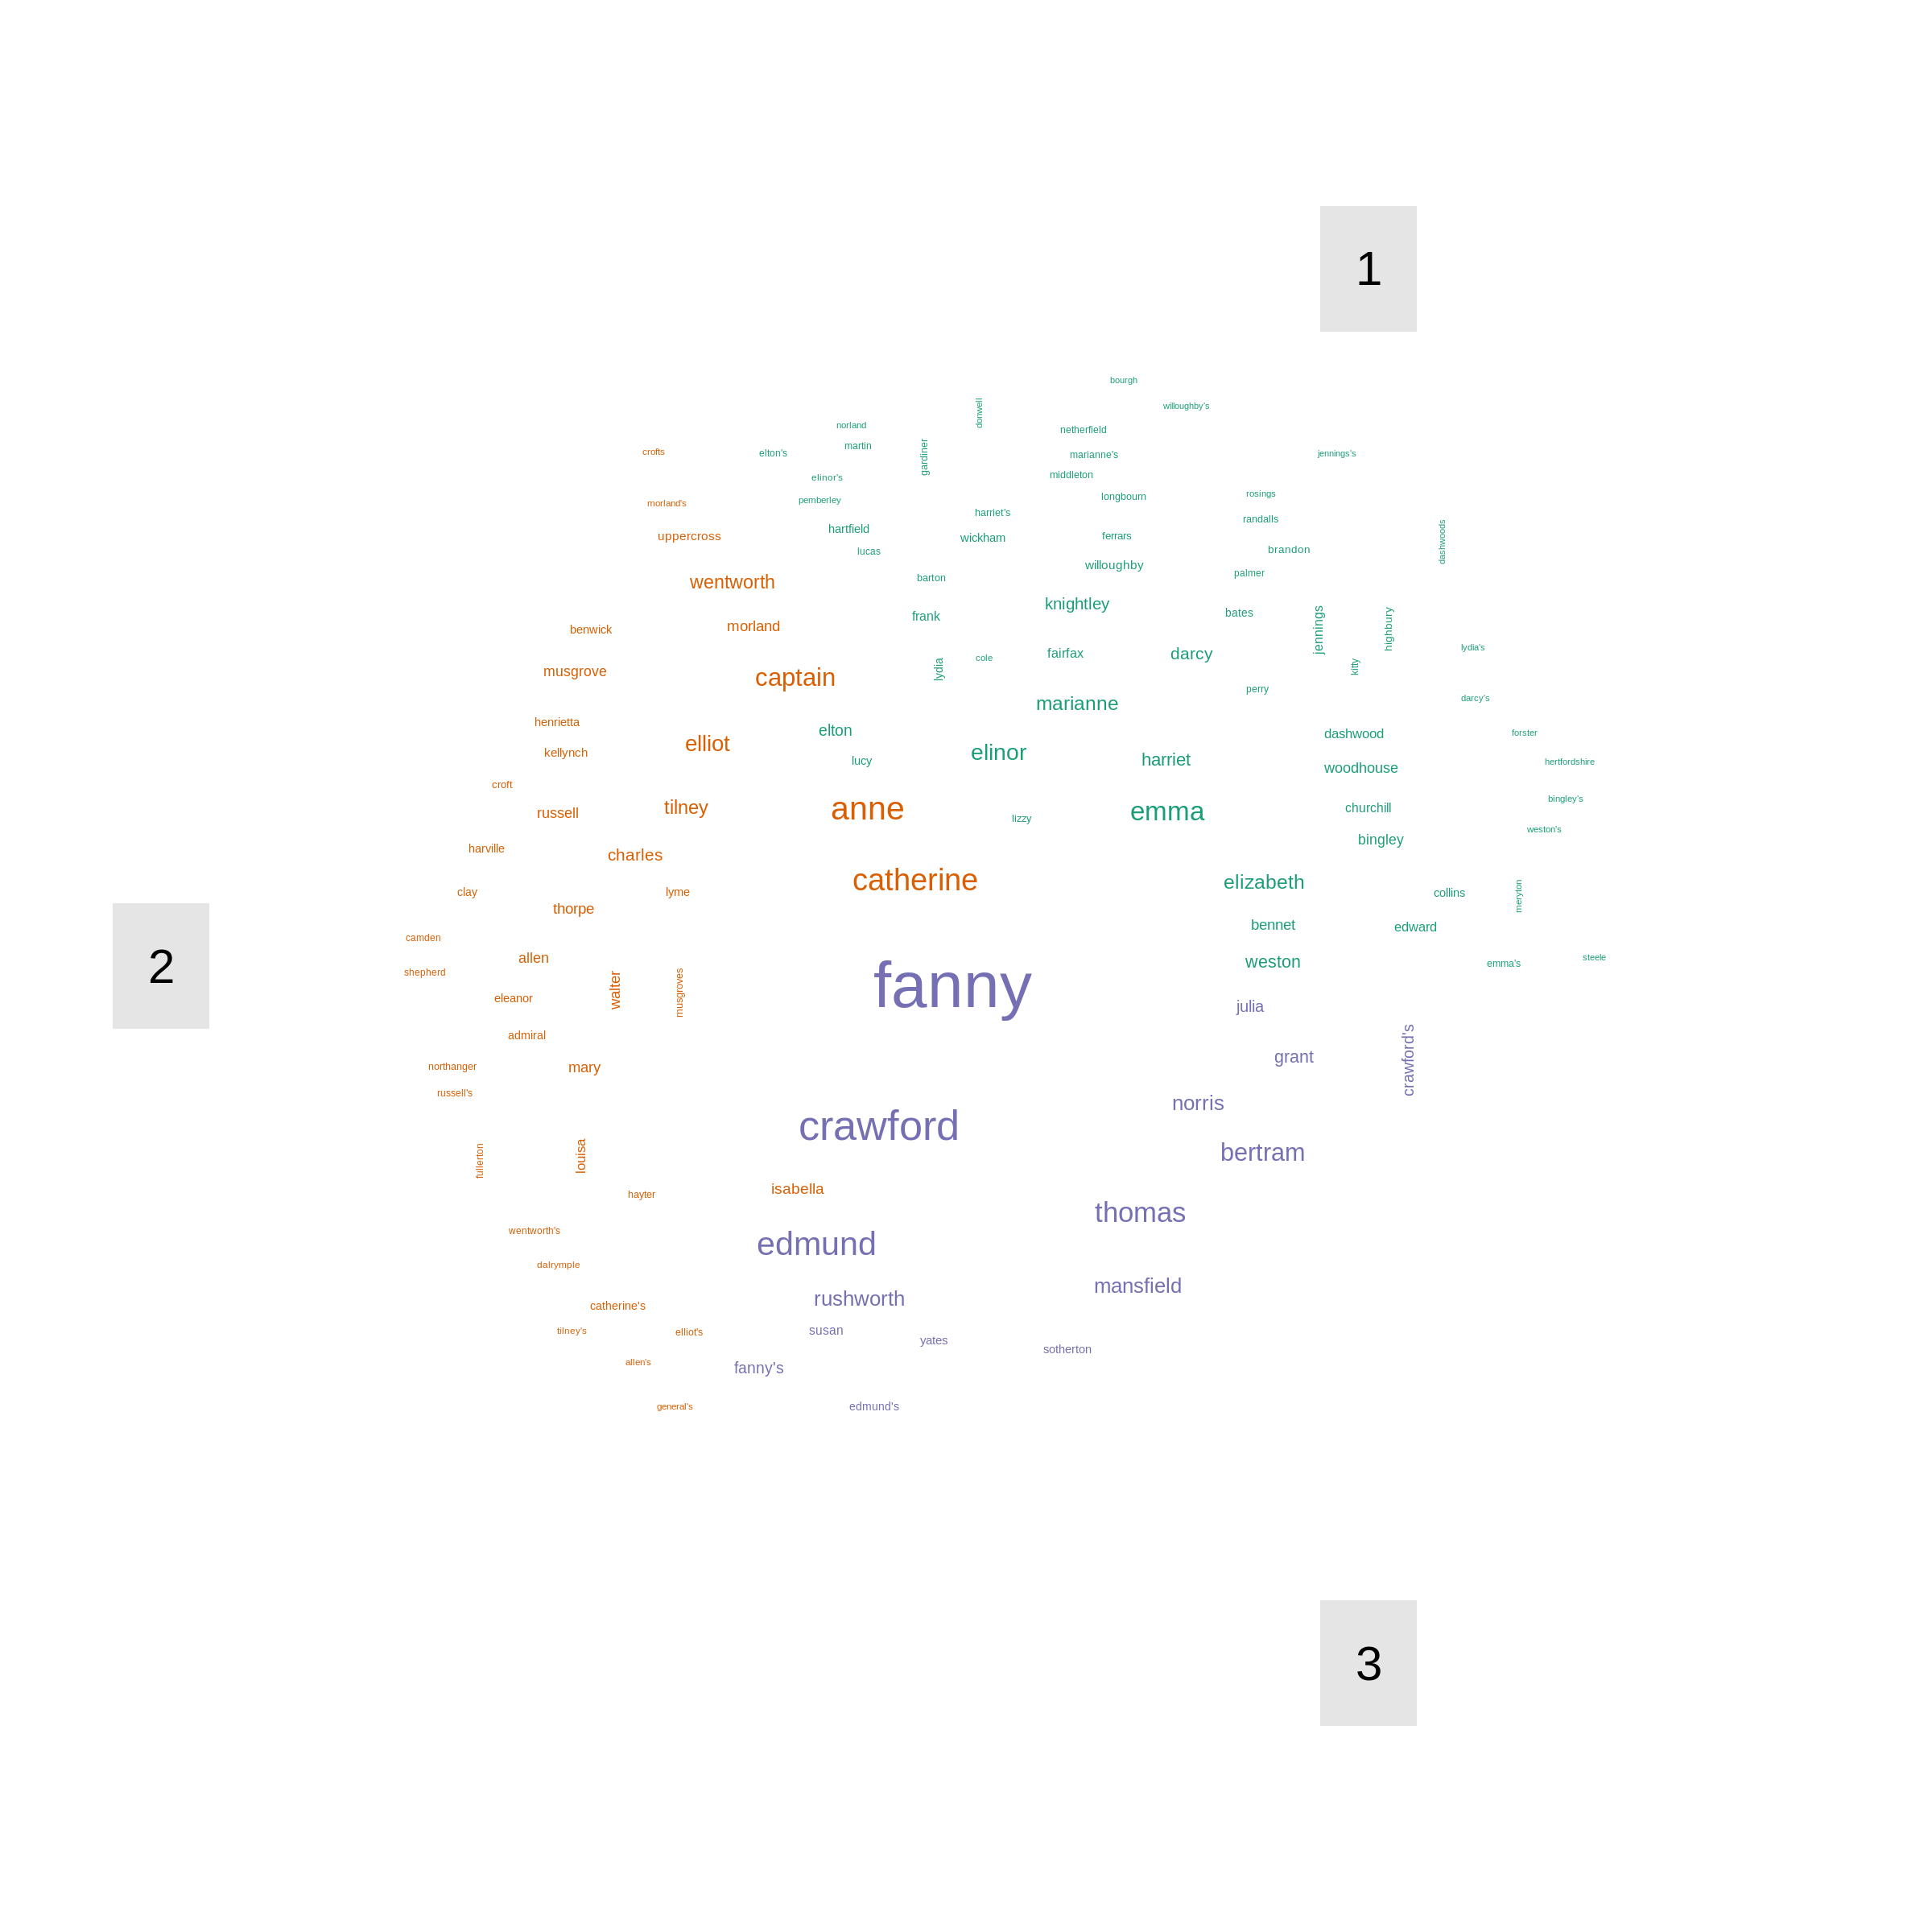

In [83]:
library(wordcloud) # check https://rpubs.com/brandonkopp/creating-word-clouds-in-r for more info
par(mfrow = c(1,1))
ttdm <- topics %>% cast_dtm(topic, term, beta) # let us now treat the topic as the "document"
m <- as.matrix(tm) # now the rows are the topics
m <- t(m) # we need them to be the columns
colnames(m) <- 1:k
head(m)
comparison.cloud(m, random.order = FALSE)

It is a bit sparse as we thresholded heavily earlier when we filtered. We can redo it with more terms present and mess with different values of `k`.

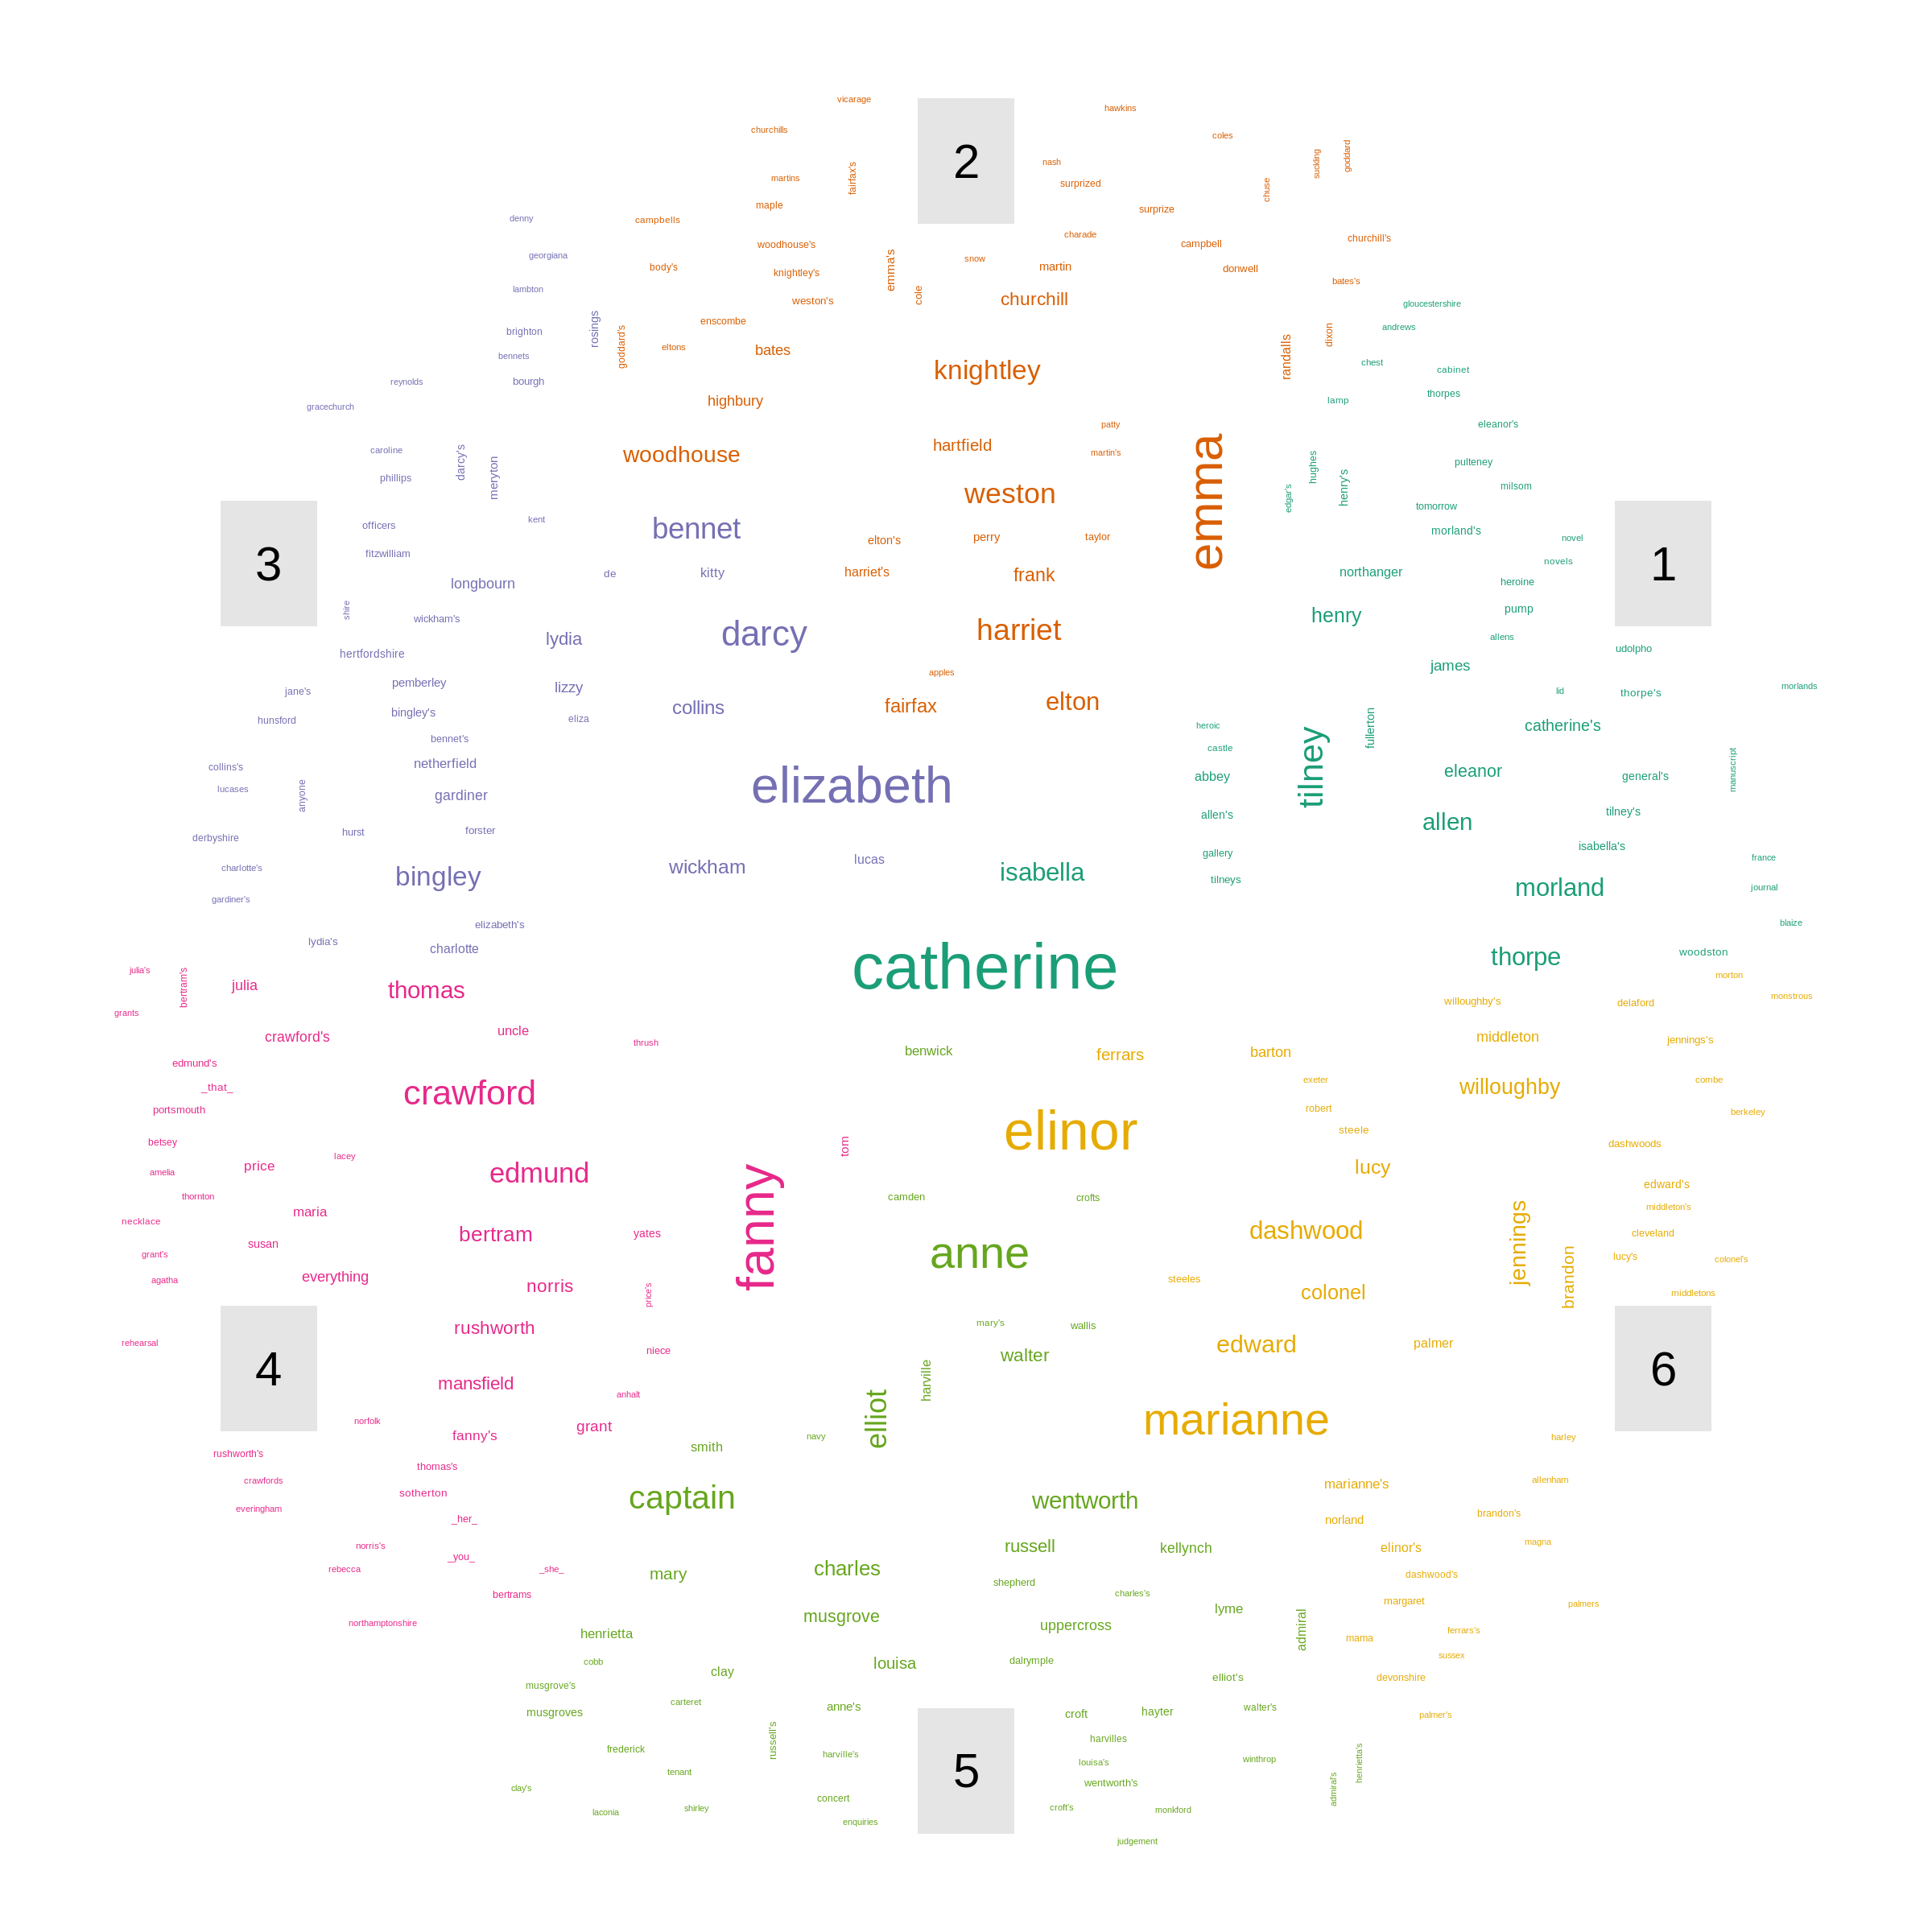

In [87]:
threshold <- 0.0001
more <- wf %>% filter (tf_idf > threshold) 
dtm <- more %>% cast_dtm(book, word, n) 
k <- 6 
topics <- tidy(LDA(dtm, k), matrix = "beta")
tm <- topics %>% cast_dtm(topic, term, beta) # let us now treat the topic as the "document"
m <- t(as.matrix(tm))
colnames(m) <- 1:k
comparison.cloud(m, random.order = FALSE)

So, do these topics correspond to the books that we originally had in the corpus? Yet another excellent exercise ;)